## Exercise - Cosmological Parameters From Type Ia Supernova Data

In this exercise we will work with some type Ia supernova data.  This is part of the data used to determine that Universe's expansion is accelerating.

Data obtained is from the Supernova Cosmology Project at:
http://supernova.lbl.gov/union/descriptions.html#Magvsz

**Background:**

The observed magnitude of an object with luminosity $L$ is

$m = - 2.5 \log\left( \frac{L}{2\pi D_L^2} \right) + m_o = 5 \log\left( D_L \right) + 2.5 \log\left( L \right) + m_o$

where $D_L$ is the luminosity distance and $m_o$ is the zero point, a constant.  The peak luminosity of a type Ia supernovae 
is directly related to the width of its lightcurve and its color.  In this data set, the correction to a standard candle has already been done by fitting light curves (see previous example).  In the data the corrected apparent magnitude is reported in terms of the estimated distance modulus

$\mu = 5 \log\left( D_L \right) - \mu_o$

This assumes a Hubble constant ($D_L \propto 1/H_o$) and requires a calibration using other distance indicators in local galaxies so there is an additive constant in the distance modulus (or a multiplicative constant to the brightness) that is not very well constrained, i.e. the relative magnitudes of the supernovae are well measured, but not their absolute brightnesses.

General relativity and the energy content of the Universe predicts a function for $D_L(z)$ (or $\mu(z)$) where $z$ is the cosmological redshift of the supernovae.  The relation depends on the density of the universe in matter $\Omega_{matter}$ and the energy density of the cosmological constant $\Omega_{\Lambda}$.  Both are in units of the critical density and must be greater than or equal to 0 and less than or equal to 1.

In this tutorial we will make and test some models for $\mu(z)$.  It will be assumed that the redshifts are very well measured so that their errors do not need to be taken into account (We will also ignore peculiar velocities.) and that the errors in the measured $\mu(z)$'s are normally distributed.

1) Import the data using the command. 

`data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')`

Note that there are comments starting with 
"#" and the seporators are tabs not commas.

Plot the distance modulus vs redshift with error bars and no line connecting the points.  Label the axes.

/tmp/ipykernel_2176/1193340764.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pa
/tmp/ipykernel_2176/1193340764.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.errorbar(z,mu,errors, ls='none',fmt='--',capsize=2,elinewidth=0.5)


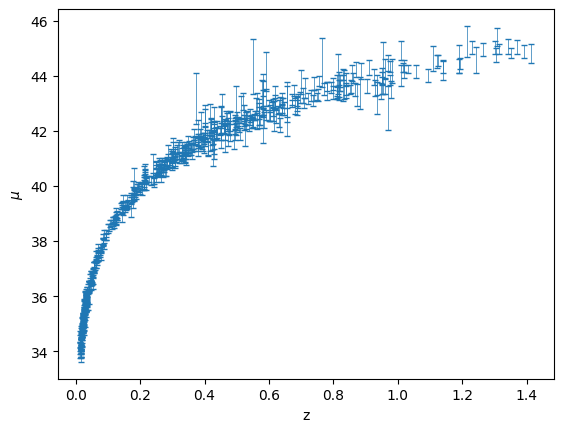

In [1]:
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt

data = pa.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')

#data.info()

z = data['redshift']
mu = data['dist_mod']
errors = data['dist_mod_error']
plt.errorbar(z,mu,errors, ls='none',fmt='--',capsize=2,elinewidth=0.5)

plt.title('')
plt.ylabel(r'$\mu$')
plt.xlabel('z')
plt.show()


2) Write a function that takes redshift, $\mu_o$, $\Omega_m$, $\Omega_\Lambda$ and returns $\mu(z)$.  
Use the library function astropy.cosmology.LambdaCDM.luminosity_distance(z).value 
to calculate the luminosity distance. The Hubble parameter is not separable from $\mu_o$ so just use $H_o = 70$ in this function.

The function should take all the parameters as if they are in a python dictionary.  For example `p['Omega_matter']` for $\Omega_{matter}$.

The parameters p should be :

`p['mu_o']` is the absolute magnitude normalization, $\mu_o$

`p['Omega_matter']` is $\Omega_{matter}$.

`p['Omega_lambda']` is $\Omega_\Lambda$.

This is a nonlinear function of the $\Omega$'s and a linear function of $\mu_o$.

In [2]:
from scipy.optimize import curve_fit
import astropy.cosmology as cosmo
import numpy as np

def mu_function(redshift,p) :
    cosmology = cosmo.LambdaCDM(70, p['Omega_matter'].value, p['Omega_lambda'].value)
    dl = cosmology.luminosity_distance(redshift).to_value()
    return 5*np.log10(dl) + p['mu_o'].value


3) Write a function that calculates $\chi^2$ given the data.  It should be a function of `p` only.  Your `mu_function()` should be used inside it.

In [3]:
mu_model = np.zeros_like(z)
def my_chi2(p) :
    mu_model = mu_function(z.to_numpy(copy=True),p)
    return np.sum(((mu - mu_model)/errors)**2)

There are a number of library functions available to minimize functions including `scipy.optimize.minimize` (which we used in the last exercise) and `scipy.optimize.curve_fit`.  Here we will use a powerful library [`lmfit`](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) because it will allow us to easily minimize the function while keeping some parameters constant without having to re-write our $\chi^2$ function.  You might have to install this library with `pip install lmfit`.

For this library the the parameters are defined in a tuple of tuples and used like a dictionary.  Each parameter has a name (the same one you used to call it above), an intial value, a boolian flag that determines if that parameter will be varied when optimizing, and then two numbers giving the allowed range.

Here is an example:

In [4]:
# pip install lmfit
import lmfit

p = lmfit.Parameters()
p.add_many(('Omega_matter',1.0,True,0,1)
           ,('Omega_lambda',0.0,True,0,1)
           ,('mu_o',24.9,True,10,30))

4) Use `lmfit.minimize` and the $\chi^2$ function you wrote above to find the $\mu_o$ 
$\Omega_m$ and $\Omega_\Lambda$ that minimize the $\chi^2$.  Print the best fit parameter values.  
Use `method='Nelder'` in `lmfit.minimize`.  Look at the structure it returns to understand how to access the parameter values. 

In [5]:
best_fit_result = lmfit.minimize(my_chi2,p,method='Nelder')
lmfit.printfuncs.report_fit(best_fit_result.params)

## here is how to access the results of the minimization
print('best fit value for Omega_matter: ', best_fit_result.params['Omega_matter'].value)
print('best fit value for Omega_Lambda: ', best_fit_result.params['Omega_lambda'].value)
print('best fit chi2: ' , my_chi2(best_fit_result.params))

[[Variables]]
    Omega_matter:  0.27914985 (init = 1)
    Omega_lambda:  0.72503222 (init = 0)
    mu_o:          24.9997301 (init = 24.9)
best fit value for Omega_matter:  0.2791498539264884
best fit value for Omega_Lambda:  0.725032221942054
best fit chi2:  562.2261096075133


5) Plot the best fit model over the data as already plotted using the functions already defined.

/tmp/ipykernel_2176/2535255237.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.errorbar(z,mu,errors, ls='none',fmt='--',capsize=2,elinewidth=0.5)


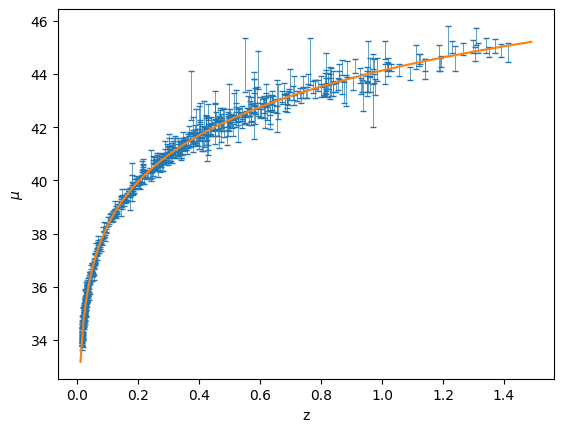

In [6]:
zz = np.arange(0.01,1.5,0.01)
m = mu_function(zz, best_fit_result.params)

plt.errorbar(z,mu,errors, ls='none',fmt='--',capsize=2,elinewidth=0.5)
plt.plot(zz,m)
plt.ylabel(r'$\mu$')
plt.xlabel('z')
plt.show()

6) At the best fit parameter values, give the p-value and confidence level.  

In [7]:
from scipy.stats import chi2

chisq = my_chi2(best_fit_result.params)
print('chi-squared = ', chisq)
print('confidence level = ',chi2.cdf(chisq,len(z)))
print('p-value = ',chi2.sf(chisq,len(z)))

chi-squared =  562.2261096075133
confidence level =  0.30584540694058776
p-value =  0.6941545930594123


7) Now assume that $\Omega_\Lambda = 0$ (no cosmological constant).  What is the best fit $\Omega_m$ and $m_o$ in this case?

In [8]:
q = lmfit.Parameters()
q.add_many(('Omega_matter',1.0,True,0,1)
           ,('Omega_lambda',0, False)
           ,('mu_o',24.9,True,10,30))

best_fit_result0 = lmfit.minimize(my_chi2,q,method='Nelder')
lmfit.printfuncs.report_fit(best_fit_result0.params)

chisq0 = my_chi2(best_fit_result0.params)
print('------------------------------------------------')
print('best fit chi2 :', chisq0)
print('confidence level = ', chi2.cdf(chisq0, len(z)))
print('p-value = ', chi2.sf(chisq0, len(z)))

[[Variables]]
    Omega_matter:  1.9838e-10 (init = 1)
    Omega_lambda:  0 (fixed)
    mu_o:          25.0779147 (init = 24.9)
------------------------------------------------
best fit chi2 : 603.3779009708707
confidence level =  0.7570667786633896
p-value =  0.24293322133661047


8) Plot in 2 dimensions ($\Omega_m$ vs $\mu_o$) the 68%, 95% and 99% confidence regions. (Hint: this will involve creating a new parameter set for each point in the 2D $\Omega_m$ - $\mu_o$ and using `lmfit.minimize`.  You also might want to use `method='powell'`)  This may take a little while to run.

1.0265485897553805 1.0985094375893811 1.1416566515231321
20
20
(20, 20)


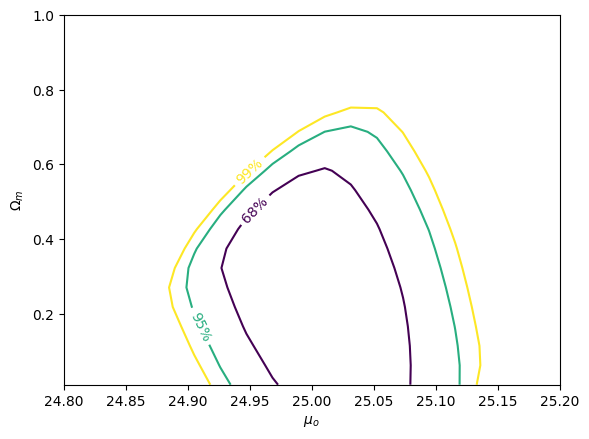

In [9]:

n = len(z) 

cl68 = chi2.ppf(0.68, n)
cl95 = chi2.ppf(0.95, n)
cl99 = chi2.ppf(0.99,n)

print(cl68/n,cl95/n,cl99/n)

mus=np.linspace(24.8,25.2,20)
#mus=np.linspace(4.85,5.15,20)
omegas=np.linspace(0.01,1.0,20)
x2d,y2d = np.meshgrid(mus,omegas)

print(len(mus))
print(len(omegas))
print(x2d.shape)

X2 = np.zeros(x2d.shape)
for i in range(0,len(mus)) :
    for j in range(0,len(omegas)) :
        p = lmfit.Parameters()
        p.add_many(('Omega_matter', omegas[j], False) 
           ,('Omega_lambda',0., True, 0.,1.)
           ,('mu_o',mus[i], False))
        best_fit_result = lmfit.minimize(my_chi2,p,method = 'powell')
        X2[j,i] = my_chi2(best_fit_result.params)

fig, ax = plt.subplots()
CS = ax.contour(x2d,y2d,X2,[cl68,cl95,cl99])
## the stupidly complicated way contours are labeled 
fmt = {}
strs = [ '68%', '95%', '99%']
for i,s in zip( CS.levels, strs ):
    fmt[i] = s

ax.clabel(CS, inline=True, fontsize=10,fmt=fmt)

plt.xlabel(r'$\mu_o$')
plt.ylabel(r'$\Omega_m$')
plt.show()


9) Do the same, but for a confidence level plot in the $\Omega_\Lambda$ - $\Omega_m$ plane.  You can reuse a lot of the code from the previous cell.  

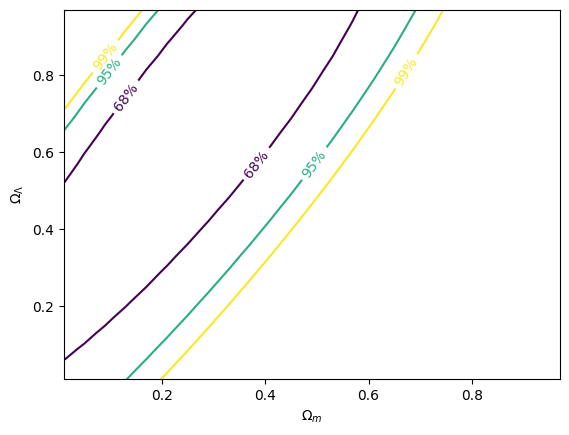

In [10]:

omega_m=np.arange(0.01,1.0,0.04)
omega_l=np.arange(0.01,1.0,0.04)
x2d,y2d = np.meshgrid(omega_m,omega_l)

X2 = np.zeros(x2d.shape)

for i in range(0,len(omega_m)) :
    for j in range(0,len(omega_l)) :
        p = lmfit.Parameters()
        p.add_many(('Omega_matter', omega_m[i], False) 
           ,('Omega_lambda',omega_l[j], False)
           ,('mu_o',24.9, True, 10,30))
        best_fit_result = lmfit.minimize(my_chi2,p,method='powell')
        X2[j,i] = my_chi2(best_fit_result.params)

fig, ax = plt.subplots()
CS = ax.contour(x2d,y2d,X2,[cl68,cl95,cl99])
## the stupidly complicated way contours are labeled 
fmt = {}
strs = [ '68%', '95%', '99%']
for i,s in zip( CS.levels, strs ):
    fmt[i] = s

ax.clabel(CS, inline=True, fontsize=10,fmt=fmt)

plt.ylabel(r'$\Omega_\Lambda$')
plt.xlabel(r'$\Omega_m$')
plt.show()

10) We want to find the 68%, 95% and 99% confidence regions for $\Omega_m$ alone.  First plot $\chi^2$ as a function of $\Omega_m$ alone.  Put some horizontal dotted lines at 
the $\chi^2$ values for the three confidence levels.

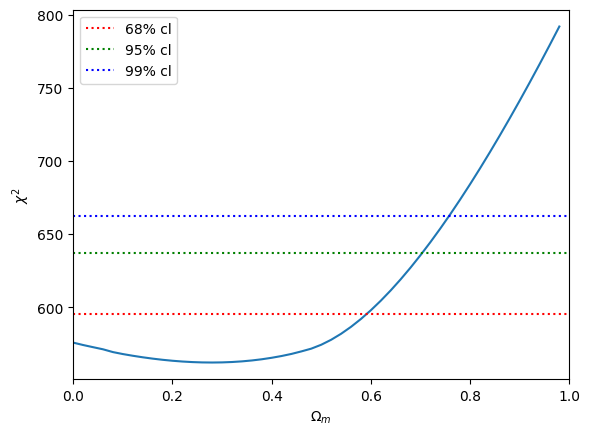

In [11]:

omega_m=np.arange(0.0,1.0,0.02)
X2 = np.zeros(len(omega_m))
for i in range(0,len(omega_m)) :
      p = lmfit.Parameters()
      p.add_many(('Omega_matter', omega_m[i], False) 
           ,('Omega_lambda',0., True, 0.,1.)
           ,('mu_o',24.9,True, 10,30))
      best_fit_result = lmfit.minimize(my_chi2, p, method = 'powell')
      X2[i] = my_chi2(best_fit_result.params)


plt.plot(omega_m,X2)

plt.plot([0,1.0], [cl68,cl68], linestyle=':',label=r'68% cl', color = 'r')
plt.plot([0,1.0], [cl95,cl95], linestyle=':',label=r'95% cl', color = 'g')
plt.plot([0,1.0], [cl99,cl99], linestyle=':',label=r'99% cl', color = 'b')
plt.xlim(0,1)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\chi^2$')
plt.legend()
plt.show()

11) Now imagine that we know from some other observations that $\Omega_m=0.5$.  Make the same plot, but for $\Omega_\Lambda$ and $\Omega_m=0.5$.  

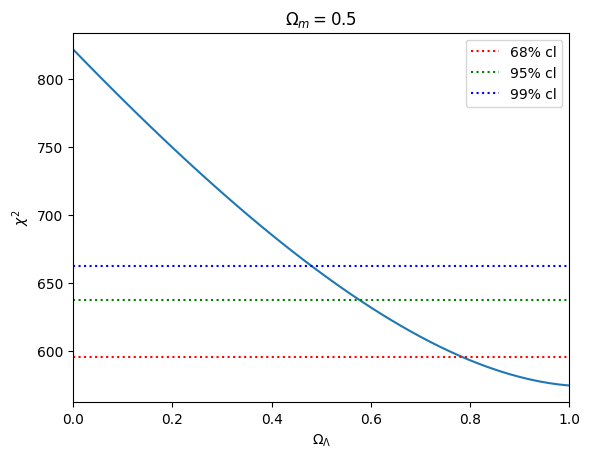

In [12]:
step = 0.02
omega_l=np.arange(0.0,1.0 + step, step) #in this way I include 1.0 as final point
X2 = np.zeros(len(omega_l))

for i in range(0,len(omega_l)) :
      p = lmfit.Parameters()
      p.add_many(('Omega_matter', 0.5 , False) 
           ,('Omega_lambda', omega_l[i] , False)
           ,('mu_o',24.9,True, 10,30))
      best_fit_result = lmfit.minimize(my_chi2, p, method = 'powell')
      X2[i] = my_chi2(best_fit_result.params)

plt.plot(omega_l, X2)

plt.plot([0,1.0], [cl68,cl68] ,linestyle=':',label=r'68% cl', color = 'r')
plt.plot([0,1.0], [cl95,cl95] ,linestyle=':',label=r'95% cl', color = 'g')
plt.plot([0,1.0], [cl99,cl99] ,linestyle=':',label=r'99% cl', color = 'b')
plt.xlim(0,1)
plt.xlabel(r'$\Omega_\Lambda$')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\Omega_m=0.5$')
plt.legend()
plt.show()

12) What are the 68%, 95% and 99% confidence regions for $\Omega_\Lambda$ *given that $\Omega_m=0.5$*? 

Taking into account that $0<\Omega_\Lambda<1$?  We can find these by finding the ranges in $\Omega_m$ where the $\chi^2$ vector created above is the limits (cl68, cl95, cl99)  found before.  (hint: I used numpy.argwhere() for this, but you can do it multiple ways.)

In [13]:
from scipy.interpolate import interp1d

index = np.argwhere(X2<cl68)
print('68% confidence level : ', np.min(omega_l[index]) ,'< Omega_l <', np.max(omega_l[index]) )
index = np.argwhere(X2<cl95)
print('95% confidence level : ', np.min(omega_l[index]) ,'< Omega_l <', np.max(omega_l[index]) )
index = np.argwhere(X2<cl99)
print('99% confidence level : ', np.min(omega_l[index]) ,'< Omega_l <', np.max(omega_l[index]) )

68% confidence level :  0.8 < Omega_l < 1.0
95% confidence level :  0.58 < Omega_l < 1.0
99% confidence level :  0.5 < Omega_l < 1.0


13) Let us experiment.  We hypothesize that there is an extra source of error in the standard candle correction procedure that was not taken into account.  The standard deviation of this error will be the parameter `p['extra_sig']`.  This error is statistically independent of the errors already given in the data file and normally distributed.  Find the maximum likelihood estimate for this extra parameter.  Minimizing the $\chi^2$ with respect to `p['extra_sig']` will not work in this case (why?).

Write a function that returns the negative of the log of the likelihood ($-\ln(L)$).  It will be like the $\chi^2$ function you already wrote.  Minimize it with `lmfit.minimize()`.

Is there a significant contribution from this extra source of noise?
Would it change the best fit cosmological parameters?


In [14]:
def neg_lnL(p) :
    mu_model = mu_function(z.to_numpy(copy=True),p)
    variances = p['extra_sig'].value**2 + errors**2
    neg_ln_likelihood = np.sum( np.log(variances) + (mu-mu_model)**2 / variances )
    return neg_ln_likelihood

p = lmfit.Parameters()
p.add_many(('Omega_matter',1.0,True,0,1)
           ,('Omega_lambda',0, True, 0,1)
           ,('mu_o',24.9,True,10,30)
           ,('extra_sig', 0, True))          ### in magnitudes

best_fit_result = lmfit.minimize(neg_lnL, p, method ='Nelder')
lmfit.printfuncs.report_fit(best_fit_result.params)


[[Variables]]
    Omega_matter:  0.27879022 (init = 1)
    Omega_lambda:  0.72437365 (init = 0)
    mu_o:          24.9997867 (init = 24.9)
    extra_sig:     0.00376233 (init = 0)


**Double click on this and answer the questions:**

Why can you not minimize the $\chi^2$ to find a good estimate for the extra noise?

Is there a significant contribution from this extra source of noise?

Would the existence of this extra noise change the best fit cosmological parameters?
